Model parameters: 31,043,521
Epoch [1/50] (18.3s)
Train Loss: 0.8495, Train mIoU: 0.5064
Val Loss: 0.8128, Val mIoU: 0.6299
Best mIoU: 0.6299
------------------------------------------------------------
Epoch [2/50] (17.5s)
Train Loss: 0.7884, Train mIoU: 0.6508
Val Loss: 0.7649, Val mIoU: 0.6788
Best mIoU: 0.6788
------------------------------------------------------------
Epoch [3/50] (17.5s)
Train Loss: 0.7567, Train mIoU: 0.6851
Val Loss: 0.7399, Val mIoU: 0.6911
Best mIoU: 0.6911
------------------------------------------------------------
Epoch [4/50] (17.4s)
Train Loss: 0.7256, Train mIoU: 0.7124
Val Loss: 0.7026, Val mIoU: 0.7261
Best mIoU: 0.7261
------------------------------------------------------------
Epoch [5/50] (17.3s)
Train Loss: 0.6962, Train mIoU: 0.7293
Val Loss: 0.6713, Val mIoU: 0.7383
Best mIoU: 0.7383
------------------------------------------------------------
Epoch [6/50] (17.4s)
Train Loss: 0.6645, Train mIoU: 0.7439
Val Loss: 0.6515, Val mIoU: 0.7407
Best m

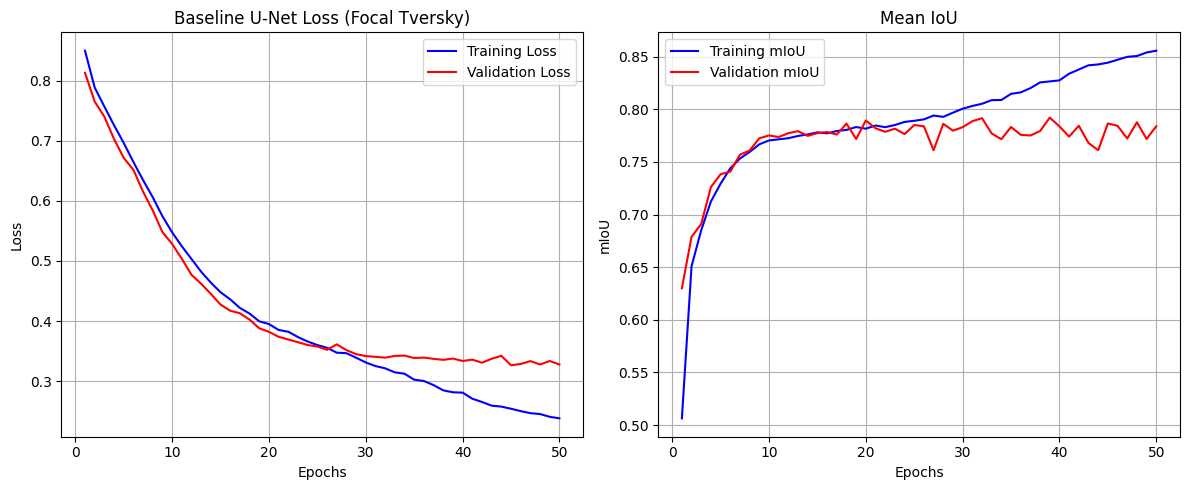


Training completed!
Best mIoU: 0.7921


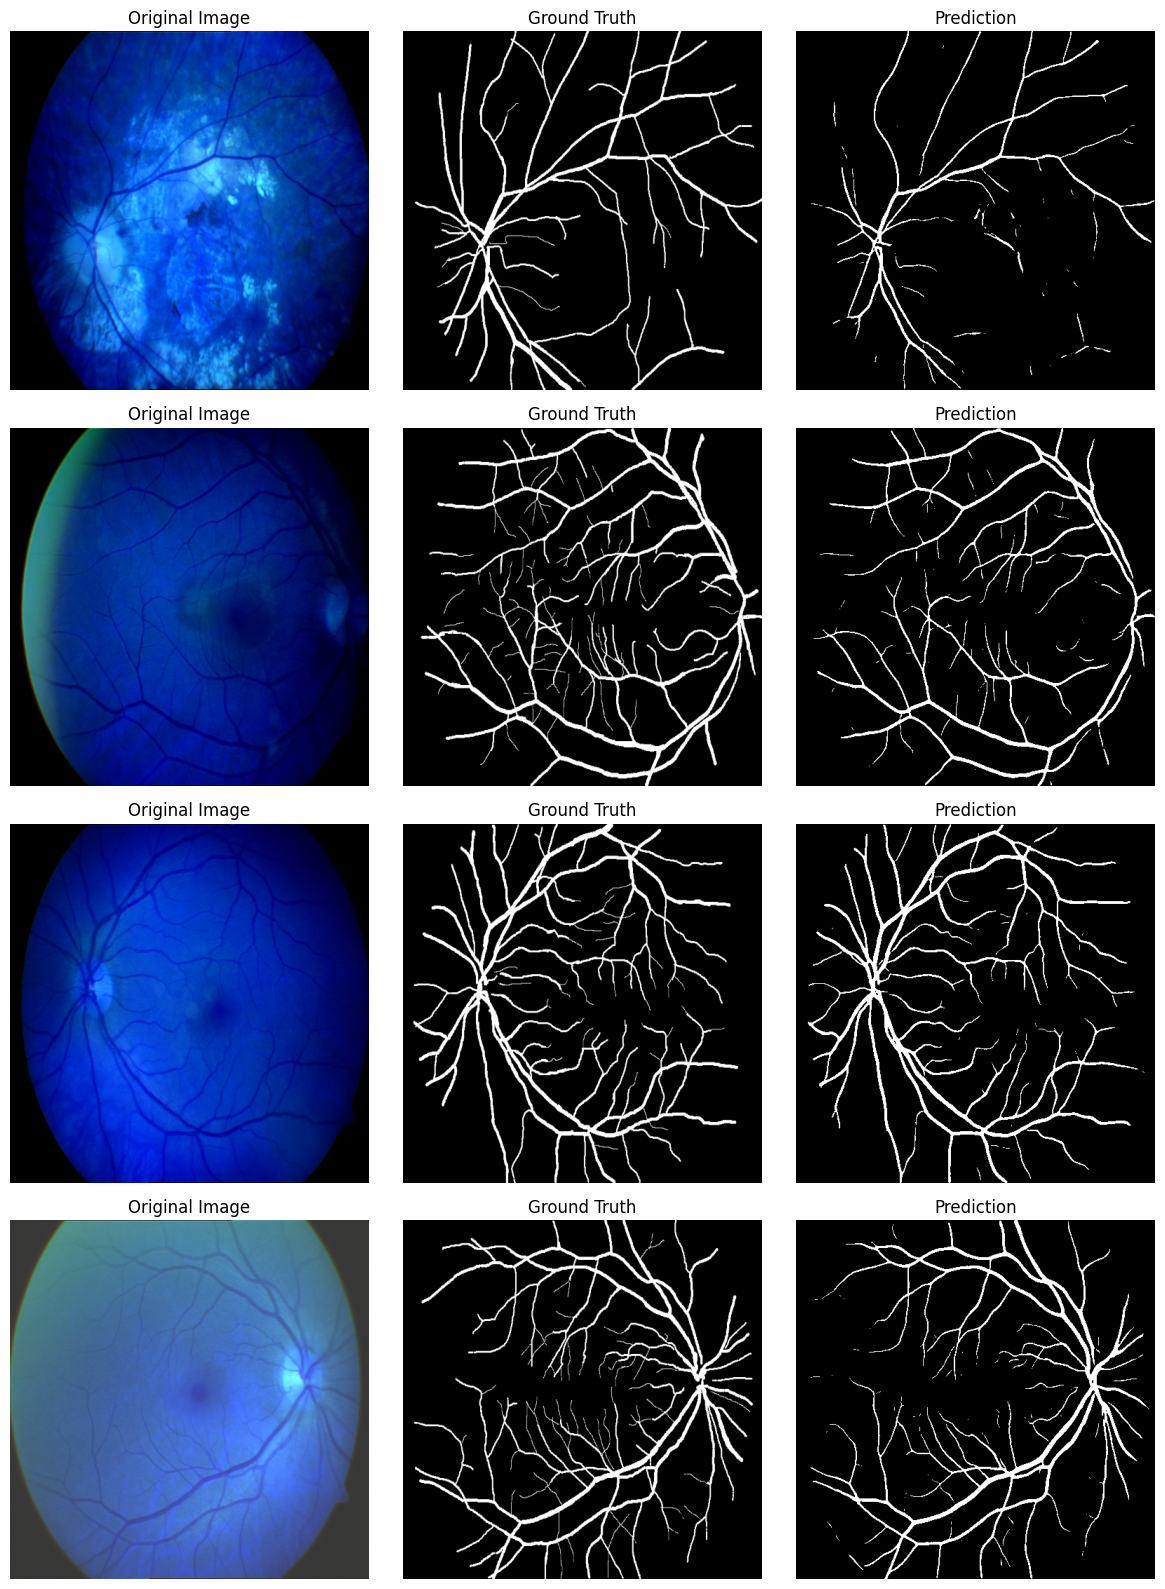

In [1]:
# Baseline U-Net for Retinal Blood Vessel Segmentation
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import glob
from tqdm import tqdm
import requests
import zipfile
import shutil
import time
import random

# =============================================================================
# 1. DATASET SETUP
# =============================================================================

def download_and_unzip(url, save_path, extract_path):
    try:
        response = requests.get(url, stream=True)
        response.raise_for_status()
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        with open(save_path, "wb") as f:
            for chunk in response.iter_content(chunk_size=8192):
                if chunk:
                    f.write(chunk)
        
        with zipfile.ZipFile(save_path, 'r') as z:
            z.testzip()
        
        temp_extract = os.path.join(os.path.dirname(save_path), "temp_extract")
        os.makedirs(temp_extract, exist_ok=True)
        with zipfile.ZipFile(save_path, 'r') as z:
            z.extractall(temp_extract)
        
        os.makedirs(extract_path, exist_ok=True)
        extracted_folders = os.listdir(temp_extract)
        if 'icpr_prepared' in extracted_folders:
            src = os.path.join(temp_extract, 'icpr_prepared')
            for item in os.listdir(src):
                src_item = os.path.join(src, item)
                dst_item = os.path.join(extract_path, item)
                if os.path.exists(dst_item):
                    if os.path.isdir(dst_item):
                        shutil.rmtree(dst_item)
                    else:
                        os.remove(dst_item)
                shutil.move(src_item, extract_path)
        
        shutil.rmtree(temp_extract)
        os.remove(save_path)
        
    except Exception as e:
        raise Exception(f"Failed to download or unzip: {str(e)}")

def setup_dataset():
    URL = r"https://www.dropbox.com/scl/fi/tscgh3pxwzfvesnu6l6uv/icpr_prepared.zip?rlkey=8oay8sod3jc1hvwhgqvylaefr&st=udj92wmp&dl=1"
    dataset_name = "retinal_blood_vessel_icpr_seg"
    dataset_zip_path = os.path.join(os.getcwd(), f"{dataset_name}.zip")
    dataset_path = os.path.join(os.getcwd(), dataset_name)

    if not os.path.exists(dataset_path):
        download_and_unzip(URL, dataset_zip_path, dataset_path)
    
    return dataset_path

def seeding(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

class RetinalDataset(Dataset):
    def __init__(self, image_dir, mask_dir, size=(512, 512)):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.size = size
        
        extensions = ["*.[tT][iI][fF]", "*.png", "*.jpg", "*.jpeg", "*.tiff", "*.bmp", "*.gif"]
        self.image_files = []
        self.mask_files = []
        
        for ext in extensions:
            self.image_files.extend(sorted(glob.glob(os.path.join(image_dir, ext))))
            self.mask_files.extend(sorted(glob.glob(os.path.join(mask_dir, ext))))
        
        self.image_files = sorted(list(set(self.image_files)))
        self.mask_files = sorted(list(set(self.mask_files)))
        
        assert len(self.image_files) == len(self.mask_files)
    
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        image_path = self.image_files[idx]
        mask_path = self.mask_files[idx]
        
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)
        image = cv2.resize(image, self.size)
        x = np.transpose(image, (2, 0, 1))
        x = x / 255.0
        x = x.astype(np.float32)
        
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, self.size)
        y = mask / 255.0
        y = y.astype(np.float32)
        
        x = torch.from_numpy(x)
        y = torch.from_numpy(y)
        y = y.unsqueeze(0)
        
        return x, y

# =============================================================================
# 2. BASELINE U-NET MODEL
# =============================================================================

class ConvBlock(nn.Module):
    """Basic convolutional block with two 3x3 convolutions"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        return x

class EncoderBlock(nn.Module):
    """Encoder block with conv block and max pooling"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv_block = ConvBlock(in_channels, out_channels)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        skip = self.conv_block(x)
        x = self.pool(skip)
        return skip, x

class DecoderBlock(nn.Module):
    """Decoder block with upsampling and conv block"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.upsample = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        self.conv_block = ConvBlock(in_channels, out_channels)

    def forward(self, x, skip):
        x = self.upsample(x)
        # Concatenate with skip connection
        x = torch.cat([x, skip], dim=1)
        x = self.conv_block(x)
        return x

class BaselineUNet(nn.Module):
    """Baseline U-Net without any bells and whistles"""
    def __init__(self, in_channels=3, out_channels=1):
        super().__init__()
        
        # Encoder path
        self.encoder1 = EncoderBlock(in_channels, 64)
        self.encoder2 = EncoderBlock(64, 128)
        self.encoder3 = EncoderBlock(128, 256)
        self.encoder4 = EncoderBlock(256, 512)
        
        # Bottleneck
        self.bottleneck = ConvBlock(512, 1024)
        
        # Decoder path
        self.decoder4 = DecoderBlock(1024, 512)
        self.decoder3 = DecoderBlock(512, 256)
        self.decoder2 = DecoderBlock(256, 128)
        self.decoder1 = DecoderBlock(128, 64)
        
        # Output layer
        self.output = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        # Encoder path
        skip1, x = self.encoder1(x)    # skip1: 64 channels
        skip2, x = self.encoder2(x)    # skip2: 128 channels
        skip3, x = self.encoder3(x)    # skip3: 256 channels
        skip4, x = self.encoder4(x)    # skip4: 512 channels
        
        # Bottleneck
        x = self.bottleneck(x)         # 1024 channels
        
        # Decoder path
        x = self.decoder4(x, skip4)    # 512 channels
        x = self.decoder3(x, skip3)    # 256 channels
        x = self.decoder2(x, skip2)    # 128 channels
        x = self.decoder1(x, skip1)    # 64 channels
        
        # Output
        x = self.output(x)             # 1 channel
        return x

# =============================================================================
# 3. FOCAL TVERSKY LOSS
# =============================================================================

class FocalTverskyLoss(nn.Module):
    def __init__(self, alpha=0.7, beta=0.3, gamma=0.75, smooth=1e-6):
        """
        Focal Tversky Loss for handling class imbalance
        
        Args:
            alpha: weight for false positives (controls precision)
            beta: weight for false negatives (controls recall)
            gamma: focal parameter to down-weight easy examples
            smooth: smoothing factor for numerical stability
        """
        super(FocalTverskyLoss, self).__init__()
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.smooth = smooth

    def forward(self, inputs, targets):
        # Apply sigmoid activation
        inputs = torch.sigmoid(inputs)
        
        # Flatten tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        # Compute Tversky Index components
        true_pos = (inputs * targets).sum()
        false_neg = (targets * (1 - inputs)).sum()
        false_pos = ((1 - targets) * inputs).sum()
        
        # Tversky Index computation
        tversky = (true_pos + self.smooth) / (
            true_pos + self.alpha * false_pos + self.beta * false_neg + self.smooth
        )
        
        # Apply focal mechanism
        focal_tversky = (1 - tversky) ** self.gamma
        
        return focal_tversky

# =============================================================================
# 4. SIMPLE METRICS
# =============================================================================

def calculate_iou(pred, target, class_id):
    """Calculate IoU for a specific class"""
    pred_mask = (pred == class_id)
    target_mask = (target == class_id)
    
    intersection = (pred_mask & target_mask).float().sum()
    union = (pred_mask | target_mask).float().sum()
    
    if union == 0:
        return None  # Class is absent, exclude from mIoU calculation
    
    return (intersection / union).item()

def calculate_miou(pred, target, num_classes=2):
    """Calculate mean IoU across all classes, excluding absent classes"""
    ious = []
    for class_id in range(num_classes):
        iou = calculate_iou(pred, target, class_id)
        if iou is not None:  # Only include classes that are present
            ious.append(iou)
    
    if len(ious) == 0:
        return 0.0  # All classes absent (shouldn't happen in practice)
    
    return np.mean(ious)

# =============================================================================
# 5. TRAINING AND VALIDATION
# =============================================================================

def train_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0.0
    total_miou = 0.0
    
    for batch_idx, (images, masks) in enumerate(dataloader):
        images = images.to(device)
        masks = masks.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
        # Calculate mIoU
        with torch.no_grad():
            pred_sigmoid = torch.sigmoid(outputs)
            pred_binary = (pred_sigmoid > 0.5).float()
            target_binary = (masks > 0.5).float()
            
            pred_class = pred_binary.long()
            target_class = target_binary.long()
            
            batch_miou = calculate_miou(pred_class, target_class)
            total_miou += batch_miou
    
    avg_loss = total_loss / len(dataloader)
    avg_miou = total_miou / len(dataloader)
    
    return avg_loss, avg_miou

def validate_epoch(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0.0
    total_miou = 0.0
    
    with torch.no_grad():
        for images, masks in dataloader:
            images = images.to(device)
            masks = masks.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, masks)
            
            total_loss += loss.item()
            
            # Calculate mIoU
            pred_sigmoid = torch.sigmoid(outputs)
            pred_binary = (pred_sigmoid > 0.5).float()
            target_binary = (masks > 0.5).float()
            
            pred_class = pred_binary.long()
            target_class = target_binary.long()
            
            batch_miou = calculate_miou(pred_class, target_class)
            total_miou += batch_miou
    
    avg_loss = total_loss / len(dataloader)
    avg_miou = total_miou / len(dataloader)
    
    return avg_loss, avg_miou

# =============================================================================
# 6. MAIN TRAINING LOOP
# =============================================================================

def main():
    # Set seed for reproducibility
    seeding(42)
    
    # Hyperparameters
    batch_size = 4
    learning_rate = 1e-4
    num_epochs = 50
    input_size = (512, 512)
    
    # Setup dataset
    dataset_path = setup_dataset()
    
    # Create datasets
    train_dataset = RetinalDataset(
        image_dir=os.path.join(dataset_path, 'train_images'),
        mask_dir=os.path.join(dataset_path, 'train_labels'),
        size=input_size
    )
    
    val_dataset = RetinalDataset(
        image_dir=os.path.join(dataset_path, 'test_images'),
        mask_dir=os.path.join(dataset_path, 'test_labels'),
        size=input_size
    )
    
    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
    
    # Initialize model
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = BaselineUNet(in_channels=3, out_channels=1)
    model = model.to(device)
    
    print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")
    
    # Loss function and optimizer - CHANGED TO FOCAL TVERSKY LOSS
    criterion = FocalTverskyLoss(alpha=0.7, beta=0.3, gamma=0.75)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)
    
    # Training loop
    best_miou = 0.0
    train_losses = []
    val_losses = []
    train_mious = []
    val_mious = []
    
    for epoch in range(num_epochs):
        start_time = time.time()
        
        # Train
        train_loss, train_miou = train_epoch(model, train_loader, optimizer, criterion, device)
        
        # Validate
        val_loss, val_miou = validate_epoch(model, val_loader, criterion, device)
        
        # Scheduler step
        scheduler.step(val_loss)
        
        # Save metrics
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_mious.append(train_miou)
        val_mious.append(val_miou)
        
        # Save best model
        if val_miou > best_miou:
            best_miou = val_miou
            torch.save(model.state_dict(), 'baseline_unet_best.pth')
        
        # Print progress
        end_time = time.time()
        epoch_time = end_time - start_time
        
        print(f'Epoch [{epoch+1}/{num_epochs}] ({epoch_time:.1f}s)')
        print(f'Train Loss: {train_loss:.4f}, Train mIoU: {train_miou:.4f}')
        print(f'Val Loss: {val_loss:.4f}, Val mIoU: {val_miou:.4f}')
        print(f'Best mIoU: {best_miou:.4f}')
        print('-' * 60)
    
    # Plot training curves
    epochs = range(1, len(train_losses) + 1)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    ax1.plot(epochs, train_losses, 'b-', label='Training Loss')
    ax1.plot(epochs, val_losses, 'r-', label='Validation Loss')
    ax1.set_title('Baseline U-Net Loss (Focal Tversky)')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)
    
    ax2.plot(epochs, train_mious, 'b-', label='Training mIoU')
    ax2.plot(epochs, val_mious, 'r-', label='Validation mIoU')
    ax2.set_title('Mean IoU')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('mIoU')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    return model, best_miou

# =============================================================================
# 7. INFERENCE AND VISUALIZATION
# =============================================================================

def predict_and_visualize(model, dataset, device, num_samples=4):
    """
    Visualize model predictions on sample images
    """
    model.eval()
    
    fig, axes = plt.subplots(num_samples, 3, figsize=(12, 4*num_samples))
    if num_samples == 1:
        axes = axes.reshape(1, -1)
    
    with torch.no_grad():
        for i in range(num_samples):
            # Get a sample
            x, y_true = dataset[i]
            x_batch = x.unsqueeze(0).to(device)
            
            # Predict
            y_pred = model(x_batch)
            y_pred_sigmoid = torch.sigmoid(y_pred)
            y_pred_binary = (y_pred_sigmoid > 0.5).float()
            
            # Convert to numpy for visualization
            x_np = x.permute(1, 2, 0).cpu().numpy()
            y_true_np = y_true.squeeze().cpu().numpy()
            y_pred_np = y_pred_binary.squeeze().cpu().numpy()
            
            # Plot
            axes[i, 0].imshow(x_np)
            axes[i, 0].set_title('Original Image')
            axes[i, 0].axis('off')
            
            axes[i, 1].imshow(y_true_np, cmap='gray')
            axes[i, 1].set_title('Ground Truth')
            axes[i, 1].axis('off')
            
            axes[i, 2].imshow(y_pred_np, cmap='gray')
            axes[i, 2].set_title('Prediction')
            axes[i, 2].axis('off')
    
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    # Train the baseline model
    model, best_miou = main()
    
    print(f"\nTraining completed!")
    print(f"Best mIoU: {best_miou:.4f}")
    
    # Optional: Visualize some predictions
    dataset_path = setup_dataset()
    val_dataset = RetinalDataset(
        image_dir=os.path.join(dataset_path, 'test_images'),
        mask_dir=os.path.join(dataset_path, 'test_labels'),
        size=(512, 512)
    )
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    predict_and_visualize(model, val_dataset, device, num_samples=4)

Baseline U-Net loaded successfully on cuda
Model parameters: 31,043,521
Starting comprehensive evaluation of Baseline U-Net model...
Evaluating 112 samples with Baseline U-Net...


100%|██████████| 28/28 [01:34<00:00,  3.36s/it]



Generating evaluation report...
Report saved to evaluation_report_baseline.txt

BASELINE U-NET - EVALUATION REPORT
Model Configuration: Standard U-Net with skip connections

PRIMARY METRICS (for early stopping):
-------------------------------------
clDice (centerline Dice):     0.3852 ± 0.0646
Dice Coefficient (binary):    0.7586 ± 0.0636

OVERLAP / REGION ACCURACY:
--------------------------
IoU (Jaccard) - Vessel:       0.6152 ± 0.0794
mIoU (mean IoU):              0.7895 ± 0.0401
IoU - Background:             0.9638 ± 0.0089

CLASS-WISE VESSEL METRICS:
--------------------------
Precision_vessel:             0.8063 ± 0.0821
Recall_vessel (Sensitivity):  0.7225 ± 0.0764
F1_vessel:                    0.7586 ± 0.0636
IoU_vessel:                   0.6152 ± 0.0794

AGGREGATED CLASSIFICATION METRICS:
----------------------------------
Sensitivity (Recall):         0.7225 ± 0.0764
Specificity:                  0.9860 ± 0.0063
Precision:                    0.8063 ± 0.0821
F1-Score:       

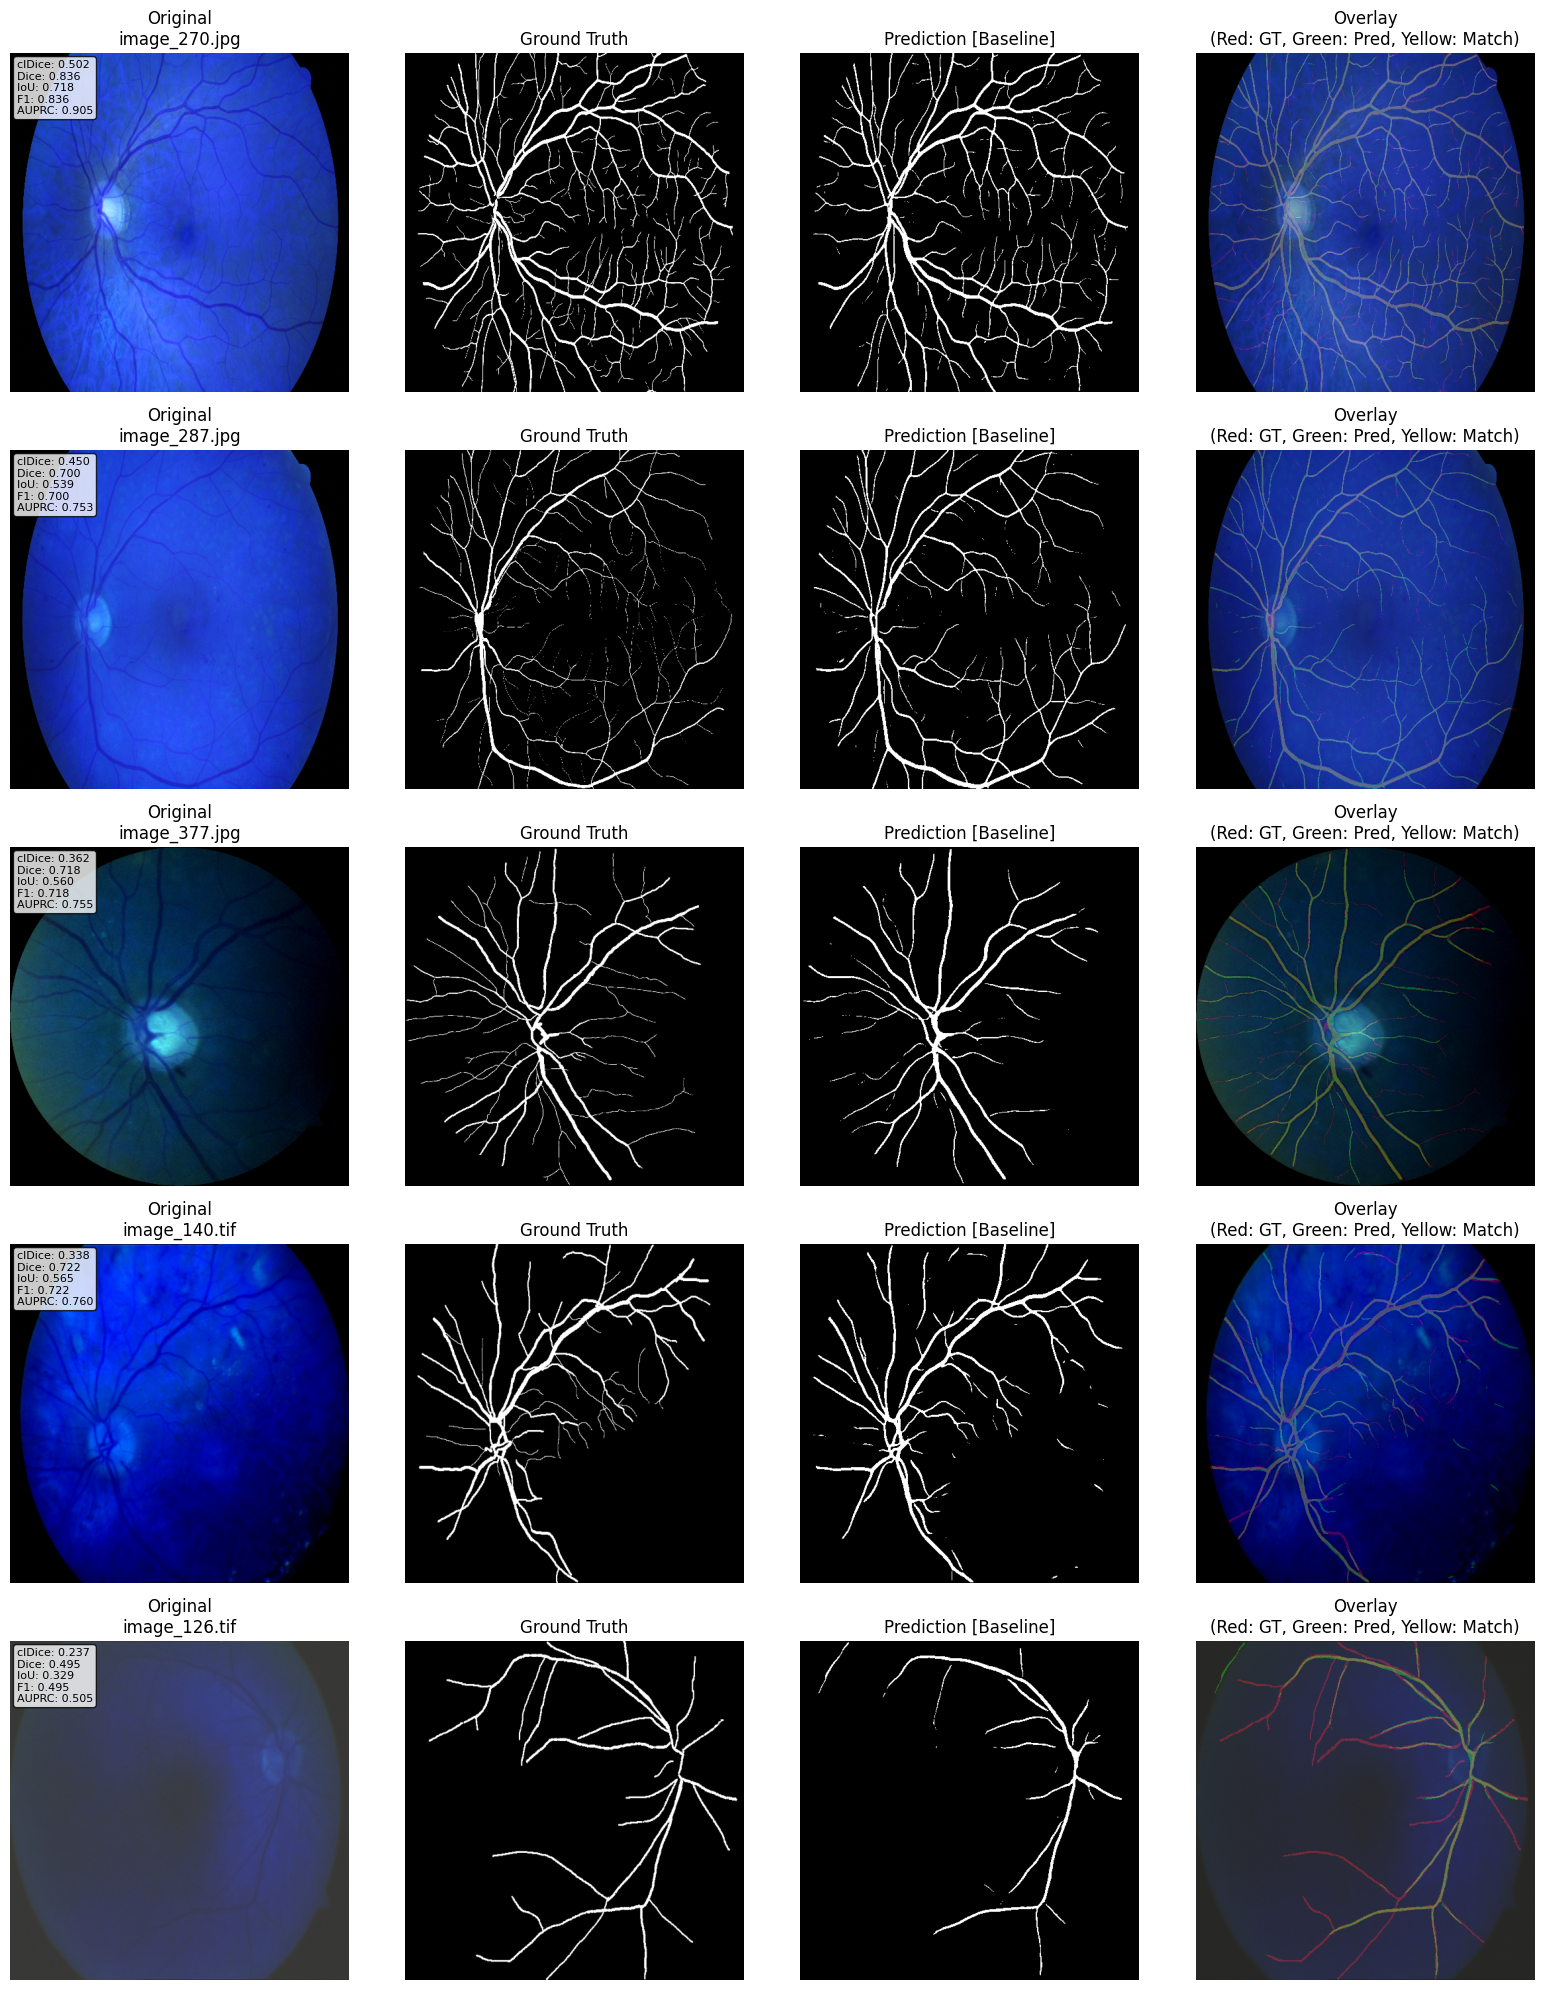


Baseline U-Net evaluation completed successfully!
- Report saved to: evaluation_report_baseline.txt
- Visualization saved to: evaluation_visualization_baseline.png

KEY PERFORMANCE METRICS [BASELINE]
clDice (Topology):     0.3852
Boundary F1:          0.8949
Vessel IoU:           0.6152
Dice Coefficient:     0.7586
F1-Score:             0.7586
AUPRC:                0.8058


In [2]:
# Standalone Evaluation and Visualization Tool for Baseline U-Net
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import glob
from tqdm import tqdm
from scipy import ndimage
from scipy.spatial.distance import directed_hausdorff
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, precision_recall_curve, auc
from skimage.morphology import skeletonize, binary_dilation, binary_erosion, remove_small_objects
from skimage.measure import label, regionprops
from skimage.segmentation import find_boundaries

# =============================================================================
# 1. BASELINE U-NET MODEL ARCHITECTURE
# =============================================================================

class ConvBlock(nn.Module):
    """Basic convolutional block with two 3x3 convolutions"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        return x

class EncoderBlock(nn.Module):
    """Encoder block with conv block and max pooling"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv_block = ConvBlock(in_channels, out_channels)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        skip = self.conv_block(x)
        x = self.pool(skip)
        return skip, x

class DecoderBlock(nn.Module):
    """Decoder block with upsampling and conv block"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.upsample = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        self.conv_block = ConvBlock(in_channels, out_channels)

    def forward(self, x, skip):
        x = self.upsample(x)
        # Concatenate with skip connection
        x = torch.cat([x, skip], dim=1)
        x = self.conv_block(x)
        return x

class BaselineUNet(nn.Module):
    """Baseline U-Net without any bells and whistles"""
    def __init__(self, in_channels=3, out_channels=1):
        super().__init__()
        
        # Encoder path
        self.encoder1 = EncoderBlock(in_channels, 64)
        self.encoder2 = EncoderBlock(64, 128)
        self.encoder3 = EncoderBlock(128, 256)
        self.encoder4 = EncoderBlock(256, 512)
        
        # Bottleneck
        self.bottleneck = ConvBlock(512, 1024)
        
        # Decoder path
        self.decoder4 = DecoderBlock(1024, 512)
        self.decoder3 = DecoderBlock(512, 256)
        self.decoder2 = DecoderBlock(256, 128)
        self.decoder1 = DecoderBlock(128, 64)
        
        # Output layer
        self.output = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        # Encoder path
        skip1, x = self.encoder1(x)
        skip2, x = self.encoder2(x)
        skip3, x = self.encoder3(x)
        skip4, x = self.encoder4(x)
        
        # Bottleneck
        x = self.bottleneck(x)
        
        # Decoder path
        x = self.decoder4(x, skip4)
        x = self.decoder3(x, skip3)
        x = self.decoder2(x, skip2)
        x = self.decoder1(x, skip1)
        
        # Output
        x = self.output(x)
        return x

# =============================================================================
# 2. DATASET CLASS
# =============================================================================

class RetinalDataset(Dataset):
    def __init__(self, image_dir, mask_dir, size=(512, 512)):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.size = size
        
        extensions = ["*.[tT][iI][fF]", "*.png", "*.jpg", "*.jpeg", "*.tiff", "*.bmp", "*.gif"]
        self.image_files = []
        self.mask_files = []
        
        for ext in extensions:
            self.image_files.extend(sorted(glob.glob(os.path.join(image_dir, ext))))
            self.mask_files.extend(sorted(glob.glob(os.path.join(mask_dir, ext))))
        
        self.image_files = sorted(list(set(self.image_files)))
        self.mask_files = sorted(list(set(self.mask_files)))
        
        assert len(self.image_files) == len(self.mask_files), "Mismatch between images and masks"
    
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        image_path = self.image_files[idx]
        mask_path = self.mask_files[idx]
        
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)
        image = cv2.resize(image, self.size)
        x = np.transpose(image, (2, 0, 1))
        x = x / 255.0
        x = x.astype(np.float32)
        
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, self.size)
        y = mask / 255.0
        y = y.astype(np.float32)
        
        x = torch.from_numpy(x)
        y = torch.from_numpy(y)
        y = y.unsqueeze(0)
        
        return x, y, os.path.basename(image_path)

# =============================================================================
# 3. COMPREHENSIVE METRICS CLASS
# =============================================================================

class ComprehensiveMetrics:
    """Standalone comprehensive evaluation metrics"""
    
    def __init__(self):
        self.results = {}
    
    def calculate_cldice(self, pred, target, smooth=1e-6):
        """Calculate centerline Dice (clDice) - Primary metric"""
        pred_np = (pred.squeeze().cpu().numpy() > 0.5).astype(bool)
        target_np = (target.squeeze().cpu().numpy() > 0.5).astype(bool)
        
        pred_skeleton = skeletonize(pred_np)
        target_skeleton = skeletonize(target_np)
        
        if not target_skeleton.any():
            return 1.0 if not pred_skeleton.any() else 0.0
        
        pred_skel_in_target = np.sum(pred_skeleton * target_np)
        target_skel_in_pred = np.sum(target_skeleton * pred_np)
        
        pred_skel_sum = np.sum(pred_skeleton)
        target_skel_sum = np.sum(target_skeleton)
        target_sum = np.sum(target_np)
        pred_sum = np.sum(pred_np)
        
        if pred_skel_sum == 0 or target_sum == 0:
            term1 = 0.0
        else:
            term1 = 2 * pred_skel_in_target / (pred_skel_sum + target_sum + smooth)
            
        if target_skel_sum == 0 or pred_sum == 0:
            term2 = 0.0
        else:
            term2 = 2 * target_skel_in_pred / (target_skel_sum + pred_sum + smooth)
        
        cldice = (term1 + term2) / 2
        return cldice
    
    def calculate_dice_coefficient(self, pred, target, smooth=1e-6):
        """Calculate Dice coefficient"""
        pred_binary = (pred > 0.5).float()
        target_binary = (target > 0.5).float()
        
        intersection = (pred_binary * target_binary).sum()
        dice = (2.0 * intersection + smooth) / (pred_binary.sum() + target_binary.sum() + smooth)
        
        return dice.item()
    
    def calculate_iou_metrics(self, pred, target, num_classes=2):
        """Calculate IoU metrics"""
        pred_class = (pred > 0.5).long()
        target_class = (target > 0.5).long()
        
        ious = []
        for class_id in range(num_classes):
            pred_mask = (pred_class == class_id)
            target_mask = (target_class == class_id)
            
            intersection = (pred_mask & target_mask).float().sum()
            union = (pred_mask | target_mask).float().sum()
            
            if union == 0:
                iou = 1.0 if intersection == 0 else 0.0
            else:
                iou = (intersection / union).item()
            ious.append(iou)
        
        return {
            'background_iou': ious[0],
            'vessel_iou': ious[1],
            'mean_iou': np.mean(ious)
        }
    
    def calculate_boundary_f1(self, pred, target, tolerance=2):
        """Calculate Boundary F1 Score"""
        pred_np = (pred.squeeze().cpu().numpy() > 0.5).astype(np.uint8)
        target_np = (target.squeeze().cpu().numpy() > 0.5).astype(np.uint8)
        
        pred_boundary = find_boundaries(pred_np, mode='inner')
        target_boundary = find_boundaries(target_np, mode='inner')
        
        if not target_boundary.any():
            return 1.0 if not pred_boundary.any() else 0.0
        
        kernel = np.ones((tolerance*2+1, tolerance*2+1), np.uint8)
        target_dilated = binary_dilation(target_boundary, kernel)
        pred_dilated = binary_dilation(pred_boundary, kernel)
        
        boundary_tp = np.sum(pred_boundary & target_dilated)
        boundary_fp = np.sum(pred_boundary & ~target_dilated)
        boundary_fn = np.sum(target_boundary & ~pred_dilated)
        
        if boundary_tp + boundary_fp == 0:
            boundary_precision = 0.0
        else:
            boundary_precision = boundary_tp / (boundary_tp + boundary_fp)
            
        if boundary_tp + boundary_fn == 0:
            boundary_recall = 0.0
        else:
            boundary_recall = boundary_tp / (boundary_tp + boundary_fn)
        
        if boundary_precision + boundary_recall == 0:
            boundary_f1 = 0.0
        else:
            boundary_f1 = 2 * boundary_precision * boundary_recall / (boundary_precision + boundary_recall)
        
        return boundary_f1
    
    def calculate_auprc(self, pred_probs, target):
        """Calculate Area Under Precision-Recall Curve"""
        pred_flat = pred_probs.cpu().numpy().flatten()
        target_flat = (target > 0.5).cpu().numpy().flatten().astype(int)
        
        if np.sum(target_flat) == 0:
            return 1.0 if np.sum(pred_flat > 0.5) == 0 else 0.0
        
        precision, recall, _ = precision_recall_curve(target_flat, pred_flat)
        auprc = auc(recall, precision)
        
        return auprc
    
    def calculate_topology_metrics(self, pred, target):
        """Calculate topology metrics"""
        pred_np = (pred.squeeze().cpu().numpy() > 0.5).astype(bool)
        target_np = (target.squeeze().cpu().numpy() > 0.5).astype(bool)
        
        pred_clean = remove_small_objects(pred_np, min_size=10)
        target_clean = remove_small_objects(target_np, min_size=10)
        
        pred_skeleton = skeletonize(pred_clean)
        target_skeleton = skeletonize(target_clean)
        
        pred_components = label(pred_skeleton)
        target_components = label(target_skeleton)
        
        pred_num_components = pred_components.max()
        target_num_components = target_components.max()
        
        component_count_delta = abs(pred_num_components - target_num_components)
        
        dilated_target_skel = binary_dilation(target_skeleton, np.ones((3, 3)))
        skeleton_overlap = np.sum(pred_skeleton & dilated_target_skel)
        total_target_skeleton = np.sum(target_skeleton)
        
        if total_target_skeleton > 0:
            skeleton_recall = skeleton_overlap / total_target_skeleton
            breaks_per_image = max(0, 1 - skeleton_recall) * target_num_components
        else:
            skeleton_recall = 1.0 if not pred_skeleton.any() else 0.0
            breaks_per_image = 0
        
        dilated_pred_skel = binary_dilation(pred_skeleton, np.ones((3, 3)))
        spurious_skeleton = pred_skeleton & ~dilated_target_skel
        spurious_branches = np.sum(spurious_skeleton) / max(1, np.sum(pred_skeleton))
        
        return {
            'breaks_per_image': breaks_per_image,
            'spurious_branches': spurious_branches,
            'component_count_delta': component_count_delta,
            'skeleton_recall': skeleton_recall
        }
    
    def evaluate_single_sample(self, prediction, target, prediction_probs=None):
        """Evaluate a single sample with all metrics"""
        pred = prediction
        target_tensor = target
        pred_prob = prediction_probs if prediction_probs is not None else pred
        
        pred_flat = (pred > 0.5).cpu().numpy().flatten().astype(int)
        target_flat = (target > 0.5).cpu().numpy().flatten().astype(int)
        
        metrics = {}
        
        # Primary metrics
        metrics['cldice'] = self.calculate_cldice(pred, target_tensor)
        metrics['dice_coefficient'] = self.calculate_dice_coefficient(pred, target_tensor)
        
        # Overlap metrics
        iou_metrics = self.calculate_iou_metrics(pred, target_tensor)
        metrics.update(iou_metrics)
        
        # Classification metrics
        metrics['sensitivity'] = recall_score(target_flat, pred_flat, zero_division=0)
        metrics['specificity'] = recall_score(1 - target_flat, 1 - pred_flat, zero_division=0)
        metrics['precision'] = precision_score(target_flat, pred_flat, zero_division=0)
        metrics['f1_score'] = f1_score(target_flat, pred_flat, zero_division=0)
        metrics['pixel_accuracy'] = accuracy_score(target_flat, pred_flat)
        
        # Boundary metrics
        metrics['boundary_f1'] = self.calculate_boundary_f1(pred, target_tensor)
        
        # Topology metrics
        topology_metrics = self.calculate_topology_metrics(pred, target_tensor)
        metrics.update(topology_metrics)
        
        # Threshold-free metrics
        metrics['auprc'] = self.calculate_auprc(pred_prob, target_tensor)
        
        return metrics

# =============================================================================
# 4. STANDALONE EVALUATOR CLASS
# =============================================================================

class StandaloneEvaluator:
    """Self-contained evaluation and visualization tool for Baseline U-Net"""
    
    def __init__(self, model_path, device=None):
        """
        Initialize evaluator with trained Baseline U-Net model
        
        Args:
            model_path: Path to saved model (.pth file)
            device: Device to run evaluation on
        """
        self.device = device if device else torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model = self.load_model(model_path)
        self.metrics_calculator = ComprehensiveMetrics()
        
        print(f"Baseline U-Net loaded successfully on {self.device}")
        print(f"Model parameters: {sum(p.numel() for p in self.model.parameters()):,}")
    
    def load_model(self, model_path):
        """Load the trained Baseline U-Net model"""
        model = BaselineUNet(in_channels=3, out_channels=1)
        model.load_state_dict(torch.load(model_path, map_location=self.device))
        model.to(self.device)
        model.eval()
        return model
    
    def evaluate_dataset(self, image_dir, mask_dir, batch_size=4, size=(512, 512)):
        """
        Evaluate Baseline U-Net model on a dataset
        
        Args:
            image_dir: Directory containing test images
            mask_dir: Directory containing ground truth masks
            batch_size: Batch size for evaluation
            size: Input image size
            
        Returns:
            Dictionary containing aggregated metrics
        """
        dataset = RetinalDataset(image_dir, mask_dir, size=size)
        dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=0)
        
        all_metrics = []
        sample_results = []
        
        print(f"Evaluating {len(dataset)} samples with Baseline U-Net...")
        
        with torch.no_grad():
            for batch_idx, (images, masks, filenames) in enumerate(tqdm(dataloader)):
                images = images.to(self.device)
                masks = masks.to(self.device)
                
                outputs = self.model(images)
                predictions = torch.sigmoid(outputs)
                
                for i in range(images.size(0)):
                    pred = predictions[i]
                    target = masks[i]
                    filename = filenames[i]
                    
                    sample_metrics = self.metrics_calculator.evaluate_single_sample(
                        prediction=pred,
                        target=target,
                        prediction_probs=pred
                    )
                    
                    sample_metrics['filename'] = filename
                    all_metrics.append(sample_metrics)
                    
                    sample_results.append({
                        'image': images[i].cpu(),
                        'ground_truth': target.cpu(),
                        'prediction': pred.cpu(),
                        'filename': filename,
                        'metrics': sample_metrics
                    })
        
        aggregated_metrics = self._aggregate_metrics(all_metrics)
        
        return aggregated_metrics, sample_results
    
    def _aggregate_metrics(self, all_metrics):
        """Aggregate metrics across all samples"""
        if not all_metrics:
            return {}
        
        aggregated = {}
        metric_keys = [key for key in all_metrics[0].keys() if key != 'filename']
        
        for key in metric_keys:
            values = [m[key] for m in all_metrics if not np.isnan(m[key]) and not np.isinf(m[key])]
            if values:
                aggregated[f'{key}_mean'] = np.mean(values)
                aggregated[f'{key}_std'] = np.std(values)
                aggregated[f'{key}_min'] = np.min(values)
                aggregated[f'{key}_max'] = np.max(values)
            else:
                aggregated[f'{key}_mean'] = 0.0
                aggregated[f'{key}_std'] = 0.0
                aggregated[f'{key}_min'] = 0.0
                aggregated[f'{key}_max'] = 0.0
        
        return aggregated
    
    def visualize_results(self, sample_results, num_samples=5, save_path=None):
        """
        Create comprehensive visualization with overlay for Baseline U-Net results
        """
        num_samples = min(num_samples, len(sample_results))
        
        sorted_samples = sorted(sample_results, key=lambda x: x['metrics']['cldice'], reverse=True)
        
        indices = [0, len(sorted_samples)//4, len(sorted_samples)//2, 3*len(sorted_samples)//4, len(sorted_samples)-1]
        selected_samples = [sorted_samples[i] for i in indices[:num_samples]]
        
        fig, axes = plt.subplots(num_samples, 4, figsize=(16, 4*num_samples))
        if num_samples == 1:
            axes = axes.reshape(1, -1)
        
        for i, sample in enumerate(selected_samples):
            image = sample['image'].permute(1, 2, 0).numpy()
            gt_mask = sample['ground_truth'].squeeze().numpy()
            pred_mask = (sample['prediction'].squeeze().numpy() > 0.5).astype(np.float32)
            
            image = np.clip(image, 0, 1)
            
            overlay = np.zeros((*gt_mask.shape, 3))
            overlay[gt_mask > 0.5] = [1, 0, 0]  # Red for ground truth
            overlay[pred_mask > 0.5] = [0, 1, 0]  # Green for prediction
            overlap = (gt_mask > 0.5) & (pred_mask > 0.5)
            overlay[overlap] = [1, 1, 0]  # Yellow for overlap
            
            alpha = 0.3
            image_overlay = image * (1 - alpha) + overlay * alpha
            
            axes[i, 0].imshow(image)
            axes[i, 0].set_title(f'Original\n{sample["filename"]}')
            axes[i, 0].axis('off')
            
            axes[i, 1].imshow(gt_mask, cmap='gray')
            axes[i, 1].set_title('Ground Truth')
            axes[i, 1].axis('off')
            
            axes[i, 2].imshow(pred_mask, cmap='gray')
            axes[i, 2].set_title('Prediction [Baseline]')
            axes[i, 2].axis('off')
            
            axes[i, 3].imshow(np.clip(image_overlay, 0, 1))
            axes[i, 3].set_title('Overlay\n(Red: GT, Green: Pred, Yellow: Match)')
            axes[i, 3].axis('off')
            
            metrics = sample['metrics']
            metrics_text = f"clDice: {metrics['cldice']:.3f}\n"
            metrics_text += f"Dice: {metrics['dice_coefficient']:.3f}\n"
            metrics_text += f"IoU: {metrics['vessel_iou']:.3f}\n"
            metrics_text += f"F1: {metrics['f1_score']:.3f}\n"
            metrics_text += f"AUPRC: {metrics['auprc']:.3f}"
            
            axes[i, 0].text(0.02, 0.98, metrics_text, transform=axes[i, 0].transAxes,
                           fontsize=8, verticalalignment='top', bbox=dict(boxstyle='round', 
                           facecolor='white', alpha=0.8))
        
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"Visualization saved to {save_path}")
        
        plt.show()
    
    def generate_report(self, aggregated_metrics, save_path=None):
        """Generate comprehensive evaluation report for Baseline U-Net"""
        report = f"""
BASELINE U-NET - EVALUATION REPORT
==================================
Model Configuration: Standard U-Net with skip connections

PRIMARY METRICS (for early stopping):
-------------------------------------
clDice (centerline Dice):     {aggregated_metrics.get('cldice_mean', 0):.4f} ± {aggregated_metrics.get('cldice_std', 0):.4f}
Dice Coefficient (binary):    {aggregated_metrics.get('dice_coefficient_mean', 0):.4f} ± {aggregated_metrics.get('dice_coefficient_std', 0):.4f}

OVERLAP / REGION ACCURACY:
--------------------------
IoU (Jaccard) - Vessel:       {aggregated_metrics.get('vessel_iou_mean', 0):.4f} ± {aggregated_metrics.get('vessel_iou_std', 0):.4f}
mIoU (mean IoU):              {aggregated_metrics.get('mean_iou_mean', 0):.4f} ± {aggregated_metrics.get('mean_iou_std', 0):.4f}
IoU - Background:             {aggregated_metrics.get('background_iou_mean', 0):.4f} ± {aggregated_metrics.get('background_iou_std', 0):.4f}

CLASS-WISE VESSEL METRICS:
--------------------------
Precision_vessel:             {aggregated_metrics.get('precision_mean', 0):.4f} ± {aggregated_metrics.get('precision_std', 0):.4f}
Recall_vessel (Sensitivity):  {aggregated_metrics.get('sensitivity_mean', 0):.4f} ± {aggregated_metrics.get('sensitivity_std', 0):.4f}
F1_vessel:                    {aggregated_metrics.get('f1_score_mean', 0):.4f} ± {aggregated_metrics.get('f1_score_std', 0):.4f}
IoU_vessel:                   {aggregated_metrics.get('vessel_iou_mean', 0):.4f} ± {aggregated_metrics.get('vessel_iou_std', 0):.4f}

AGGREGATED CLASSIFICATION METRICS:
----------------------------------
Sensitivity (Recall):         {aggregated_metrics.get('sensitivity_mean', 0):.4f} ± {aggregated_metrics.get('sensitivity_std', 0):.4f}
Specificity:                  {aggregated_metrics.get('specificity_mean', 0):.4f} ± {aggregated_metrics.get('specificity_std', 0):.4f}
Precision:                    {aggregated_metrics.get('precision_mean', 0):.4f} ± {aggregated_metrics.get('precision_std', 0):.4f}
F1-Score:                     {aggregated_metrics.get('f1_score_mean', 0):.4f} ± {aggregated_metrics.get('f1_score_std', 0):.4f}
Pixel Accuracy:               {aggregated_metrics.get('pixel_accuracy_mean', 0):.4f} ± {aggregated_metrics.get('pixel_accuracy_std', 0):.4f}

BOUNDARY / DISTANCE METRICS:
----------------------------
Boundary F1 (BF-score):      {aggregated_metrics.get('boundary_f1_mean', 0):.4f} ± {aggregated_metrics.get('boundary_f1_std', 0):.4f}

TOPOLOGY / CONNECTIVITY:
------------------------
Skeleton/Centerline Recall:  {aggregated_metrics.get('skeleton_recall_mean', 0):.4f} ± {aggregated_metrics.get('skeleton_recall_std', 0):.4f}
Breaks per Image:             {aggregated_metrics.get('breaks_per_image_mean', 0):.2f} ± {aggregated_metrics.get('breaks_per_image_std', 0):.2f}
Spurious Branches:            {aggregated_metrics.get('spurious_branches_mean', 0):.4f} ± {aggregated_metrics.get('spurious_branches_std', 0):.4f}
Component Count Δ vs GT:     {aggregated_metrics.get('component_count_delta_mean', 0):.1f} ± {aggregated_metrics.get('component_count_delta_std', 0):.1f}

IMBALANCE-ROBUST, THRESHOLD-FREE:
---------------------------------
AUPRC (Precision-Recall AUC): {aggregated_metrics.get('auprc_mean', 0):.4f} ± {aggregated_metrics.get('auprc_std', 0):.4f}

PERFORMANCE SUMMARY:
-------------------
PRIMARY: clDice = {aggregated_metrics.get('cldice_mean', 0):.4f} (vessel topology preservation)
VESSEL:  IoU = {aggregated_metrics.get('vessel_iou_mean', 0):.4f}, F1 = {aggregated_metrics.get('f1_score_mean', 0):.4f}
ROBUST:  AUPRC = {aggregated_metrics.get('auprc_mean', 0):.4f} (threshold-independent)
CONFIG:  Standard U-Net with simple skip connections

METHODOLOGICAL NOTES:
---------------------
Standard U-Net architecture without attention mechanisms
BatchNorm normalization with ReLU activation
Simple skip connection concatenation
Focal Tversky Loss for class imbalance handling
        """
        
        if save_path:
            with open(save_path, 'w') as f:
                f.write(report)
            print(f"Report saved to {save_path}")
        
        print(report)
        return report

# =============================================================================
# 5. MAIN EVALUATION FUNCTION
# =============================================================================

def main_evaluation():
    """
    Main function to run standalone evaluation for Baseline U-Net model
    """
    # Configuration
    MODEL_PATH = "baseline_unet_best.pth"  # Path to your trained Baseline U-Net model
    DATASET_PATH = "retinal_blood_vessel_icpr_seg"    # Path to dataset folder
    
    # Check if model exists
    if not os.path.exists(MODEL_PATH):
        print(f"Error: Model file '{MODEL_PATH}' not found!")
        print("Please ensure the Baseline U-Net model file is in the current directory.")
        return
    
    # Check if dataset exists
    if not os.path.exists(DATASET_PATH):
        print(f"Error: Dataset folder '{DATASET_PATH}' not found!")
        print("Please ensure the dataset folder is in the current directory.")
        return
    
    # Initialize evaluator
    evaluator = StandaloneEvaluator(MODEL_PATH)
    
    # Define test data paths
    test_image_dir = os.path.join(DATASET_PATH, 'test_images')
    test_mask_dir = os.path.join(DATASET_PATH, 'test_labels')
    
    # Run evaluation
    print("Starting comprehensive evaluation of Baseline U-Net model...")
    aggregated_metrics, sample_results = evaluator.evaluate_dataset(
        image_dir=test_image_dir,
        mask_dir=test_mask_dir,
        batch_size=4,
        size=(512, 512)
    )
    
    # Generate report
    print("\nGenerating evaluation report...")
    evaluator.generate_report(aggregated_metrics, save_path="evaluation_report_baseline.txt")
    
    # Create visualizations
    print("\nCreating visualizations...")
    evaluator.visualize_results(sample_results, num_samples=5, save_path="evaluation_visualization_baseline.png")
    
    print("\nBaseline U-Net evaluation completed successfully!")
    print(f"- Report saved to: evaluation_report_baseline.txt")
    print(f"- Visualization saved to: evaluation_visualization_baseline.png")
    
    # Print key performance metrics
    print(f"\n{'='*60}")
    print("KEY PERFORMANCE METRICS [BASELINE]")
    print(f"{'='*60}")
    print(f"clDice (Topology):     {aggregated_metrics.get('cldice_mean', 0):.4f}")
    print(f"Boundary F1:          {aggregated_metrics.get('boundary_f1_mean', 0):.4f}")
    print(f"Vessel IoU:           {aggregated_metrics.get('vessel_iou_mean', 0):.4f}")
    print(f"Dice Coefficient:     {aggregated_metrics.get('dice_coefficient_mean', 0):.4f}")
    print(f"F1-Score:             {aggregated_metrics.get('f1_score_mean', 0):.4f}")
    print(f"AUPRC:                {aggregated_metrics.get('auprc_mean', 0):.4f}")

if __name__ == "__main__":
    main_evaluation()